## Feed-forward 신경망 연습

직접 만든 간단한 point cloud 데이터셋을 이용해 

* Raw data에 직접 클래스를 부여하고
* Training, validation 및 test set의 비율을 임의로 정한 뒤

훈련하는 분류 연습을 해 보았습니다.

$\downarrow$ 먼저, 4 dimension의 랜덤한 feature를 갖는, 적당히 500개 정도의 point 데이터들을 만들고,

In [48]:
import torch as t
from math import *
import numpy as np
import matplotlib.pyplot as plt

################# DATA POINT GENERATION ##################

t.manual_seed(3)
data_dim = 4
data_num = 500
data_tensor = t.rand((data_num,data_dim))

$\downarrow$ 흔히 사용하는 지수 및 삼각함수들을 무작위로 조합한 어떤 비선형 함수들 $f_1:\mathbb{R}^4\to\mathbb{R}^1$, $f_2:\mathbb{R}^4\to\mathbb{R}^1$ 를 만들고 데이터들이 산출하는 함숫값들을 플롯해보았습니다.

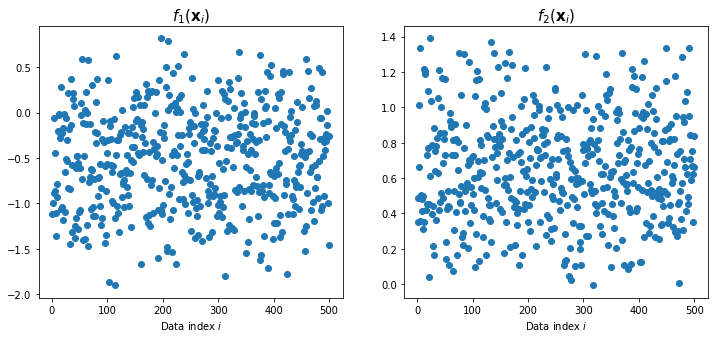

In [49]:

coeffs = t.randn(2,4)  # AUXILLIARY FUNCTION FOR ASSIGNING DATA CLASS
def f(x,y,z,w):        
    val1 = t.dot(coeffs[0,:], t.tensor([sin(x),cos(y),asin(z),acos(w)]))
    val2 = t.dot(coeffs[1,:], t.tensor([exp(x),exp(y),cosh(z),sinh(w)]))
    return val1, val2

y1 = t.zeros(data_num); y2 = t.zeros(data_num) 

for i in range(data_num):
    y1[i], y2[i] = f(*data_tensor[i,:])
  
fig,axes = plt.subplots(1,2)
x = t.arange(1,data_num+1)
axes[0].scatter(x,y1); axes[1].scatter(x,y2)
axes[0].set_title("$f_1(\mathbf{x}_i)$", fontsize=15); axes[1].set_title("$f_2(\mathbf{x}_i)$", fontsize=15)
axes[0].set_xlabel("Data index $i$"); axes[1].set_xlabel("Data index $i$")
fig.set_size_inches(12,5)
plt.show(fig)

$\downarrow$ 각 함수값의 범위에 따라 적절히 4개의 클래스로 나눠 봤습니다.
(여기서, 클래스 태그(ground truth)들은 타입을 확실히 torch 라이브러리의 정수로 해줘야 합니다. 그렇지 않으면 torch의 Loss 함수가 작동을 하지 않았습니다.)

In [50]:
############### GENERATING DATA CLASSES ################

fact1 = y1 < -0.5; fact2 = y2 < 0.6      
data_class = t.zeros(data_num,dtype=t.uint8)  
#!!! CLASS TAGS MUST BE AN INTEGER. If not, torch's loss function returns error.
for i in range(0,data_num):
    if (fact1[i] == True) and (fact2[i] == True):
        data_class[i] = 0
    elif (fact1[i] == True) and (fact2[i] == False):
        data_class[i] = 1
    elif (fact1[i] == False) and (fact2[i] == True):
        data_class[i] = 2
    else:
        data_class[i] = 3
    
print(f"Class 0: {sum(data_class == 0)} nodes")
print(f"Class 1: {sum(data_class == 1)} nodes")
print(f"Class 2: {sum(data_class == 2)} nodes")
print(f"Class 3: {sum(data_class == 3)} nodes")

Class 0: 115 nodes
Class 1: 126 nodes
Class 2: 110 nodes
Class 3: 149 nodes


$\downarrow$ 데이터셋의 40퍼센트 정도를 training set, 나머지 중 절반씩을 validation 및 test set으로 나눠 봤습니다.

In [51]:
######### MASKING TRAINING, VALIDATING, AND TESTING NODES #########

randvec = t.rand(data_num)    
train_mask = randvec < 0.4
test_mask = randvec > 0.7
val_mask = t.zeros(data_num, dtype=t.bool)
for i in range(data_num):
    if train_mask[i] == False and test_mask[i] == False:
        val_mask[i] = True
    else:
        val_mask[i] = False
    
print(f"Training set: {sum(train_mask)} nodes")
print(f"Training set: {sum(val_mask)} nodes")
print(f"Training set: {sum(test_mask)} nodes")

Training set: 201 nodes
Training set: 142 nodes
Training set: 157 nodes


$\downarrow$ 위에 만들어 둔 데이터의 정보를 하나의 데이터프레임으로 묶기 위해, 데이터셋의 속성들을 적절히 담는 클래스를 선언하고 my_data 라는 이름으로 실체화를 시켰습니다.

In [52]:
###################### DATAFRAME CLASS #######################

class dataframe:
    def __init__(self, data_tensor,data_class, trm,vm,tm, edges=None):
      
        self.num_features = data_tensor.shape[1]
        self.num_classes = int(max(data_class).item()+1)
        self.x = data_tensor
        self.num_nodes = data_tensor.shape[0]
        self.y = data_class
        self.train_mask = trm; self.val_mask = vm; self.test_mask = tm
        
        self.edge_index = edges
        if edges == None:
            self.num_edges = [None]
        else:
            self.num_edges = edges.shape[0]

#data_tensor = t.remainder(data_tensor,0.5)

my_data = dataframe( data_tensor,data_class,train_mask,val_mask,test_mask)

$\downarrow$ 이제 앞서 만들어 뒀던 순방향(feed-forward)신경망들의 학습을 위한 클래스를 선언을 가져오고,

In [73]:
################ CLASS OF FEED-FORWARD NEURAL NETS ################

class FFNN(t.nn.Module):
  
    def __init__(self, layers, activations, hidden_channels, data, 
                layer_options=False, fw_options=False, dropouts=False):
        super(FFNN,self).__init__()
        t.manual_seed(1)
        
        self.data = data
        self.activations = activations
        self.fw_options = fw_options
        self.dropouts = dropouts
        self.num_layers = len(layers)
        
        if layer_options == False:
            self.layer_options = [[] for i in range(self.num_layers)]
        if fw_options == False:
            self.fw_options = [[] for i in range(self.num_layers)]
          
        self.channels = hidden_channels
        self.channels.insert(0,self.data.num_features); 
        self.channels.append(self.data.num_classes)
        
        self.layers = [ ]
        for i in range(0,self.num_layers):
            args = [self.channels[i],self.channels[i+1]]; args.extend(self.layer_options[i])
            self.layers.append( layers[i]( *args ) )
        self.layers = t.nn.ModuleList(self.layers)
        
    def forward(self, x):
        for i in range(0,self.num_layers):
          args = [x]; args.extend(self.fw_options[i])
          x = self.activations[i]( self.layers[i]( *args ))
          if self.dropouts is not False:
              x = F.dropout(x, p=self.dropouts[i], training=self.training)
          else:
              pass
        return x

$\downarrow$ torch를 이용한 훈련 과정을 기록하는 'learn' 클래스와,

In [68]:
################ LEARNING & TESTING ROUTINE #################

class learn:
    def __init__(self, model, optimizer, criterion, epochs, data):
      
        self.data = data
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.epochs = t.arange(1,epochs+1)
        loss_vec = t.zeros((3,epochs)); acc_vec = t.zeros((3,epochs))
        
        for epoch in range(0,epochs):
          loss_vec[:,epoch], self.out = self.train_onestep()
          acc_vec[:,epoch] = self.get_accuracy(self.out)
      
        print("\n############################## LEARNING FINISHED! ##################################\n")
        
        self.train_loss = loss_vec[0,:]; self.train_acc = acc_vec[0,:]
        self.val_loss = loss_vec[1,:]; self.val_acc = acc_vec[1,:]
        self.test_loss = loss_vec[2,:]; self.test_acc = acc_vec[2,:]
      
        print(f'Test Accuracy: {self.test_acc[-1]:.4f}')
      
    def train_onestep(self):
      
        self.model.train()
        self.optimizer.zero_grad()
        out = self.model.forward(self.data.x)
        
        train_loss = self.criterion(out[self.data.train_mask], self.data.y[self.data.train_mask])
        val_loss = self.criterion(out[self.data.val_mask], self.data.y[self.data.val_mask])
        test_loss = self.criterion(out[self.data.test_mask], self.data.y[self.data.test_mask])
        train_loss.backward() 
        self.optimizer.step()  
        
        return t.tensor([train_loss, val_loss, test_loss]), out
    
    def get_accuracy(self,out):
      
        self.model.eval()
        pred = out.argmax(dim=1) 
        
        train_correct = pred[self.data.train_mask] == self.data.y[self.data.train_mask]
        val_correct = pred[self.data.val_mask] == self.data.y[self.data.val_mask]
        test_correct = pred[self.data.test_mask] == self.data.y[self.data.test_mask]
        
        train_acc = int(train_correct.sum()) / int(self.data.train_mask.sum())
        val_acc = int(val_correct.sum()) / int(self.data.val_mask.sum())
        test_acc = int(test_correct.sum()) / int(self.data.test_mask.sum())
        
        return t.tensor([train_acc, val_acc, test_acc])

$\downarrow$ 훈련이 끝난 후 learn 클래스의 인스턴스에 담긴 훈련 과정 정보들을 시각화 해주는 루틴을 쓰겠습니다.

In [55]:
from sklearn.manifold import TSNE

############### VISUALIZING ROUTINE ################

def visualize(result, progress_plot=True, TSNE_plot=False):

    if progress_plot is True:
        fig, ax = plt.subplots(1,2)
        fig.set_size_inches(15,5)
        fig.suptitle("Learning Result", fontsize = 15)
        
        loss1, = ax[0].plot( result.epochs, result.train_loss, color='b', linewidth=2 , label = "Train set")
        loss2, = ax[0].plot( result.epochs, result.val_loss, color='g', linewidth=2 , label = "Validation set")
        loss3, = ax[0].plot( result.epochs, result.test_loss, color='r', linewidth=2, label = "Test set" )
        ax[0].legend(handles = [loss1, loss2, loss3])
        ax[0].set_xlabel("Epochs")
        ax[0].set_title("Loss")

        acc1, = ax[1].plot( result.epochs, result.train_acc, color='b', linewidth=2, label = "Train set")
        acc2, = ax[1].plot( result.epochs, result.val_acc, color='g', linewidth=2, label = "Validation set" )
        acc3, = ax[1].plot( result.epochs, result.test_acc, color='r', linewidth=2, label = "Test set" )
        ax[1].legend(handles = [loss1, loss2, loss3])
        ax[1].set_xlabel("Epochs")
        ax[1].set_title("Accuracy")
        plt.show()
    else:
        pass
    
    if TSNE_plot is True:
        z = TSNE(n_components=2).fit_transform(result.out.detach().cpu().numpy())
        fig,ax = plt.subplots()
        fig.set_size_inches(7,7)
        ax.set_title('2D projection of model output',fontsize=12)
        ax.scatter(z[:,0], z[:,1], s=70, c=result.data.y, cmap="Set2")
        plt.show()
    else:
        pass

$\downarrow$ 이제 클래스 선언대로 간단히 하나의 8 채널 hidden layer를 갖는 MLP 모델을 만들고 (총 파라미터 갯수는 2*8*4 = 64개로 매우 작은 모델입니다), 전형적인 퍼셉트론 레이어들을 사용해서 training을 시켜 봤습니다.

Current model: 
FFNN(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=4, bias=True)
  )
)


C:\Users\echo_\AppData\Local\Temp\ipykernel_17272\4217564866.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activations[i]( self.layers[i]( *args ))



############################## LEARNING FINISHED! ##################################

Test Accuracy: 0.9490


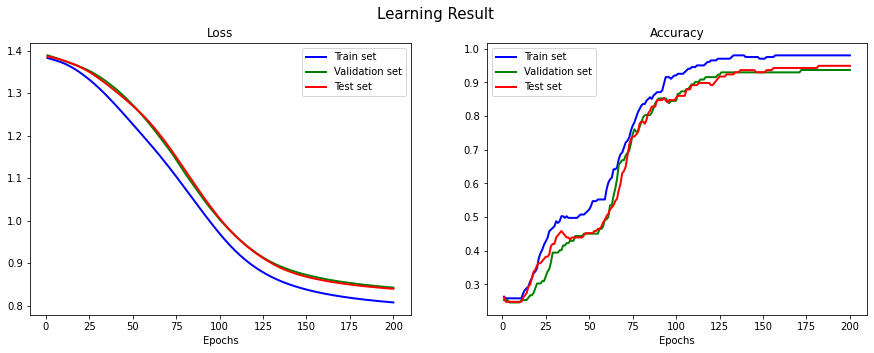

c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


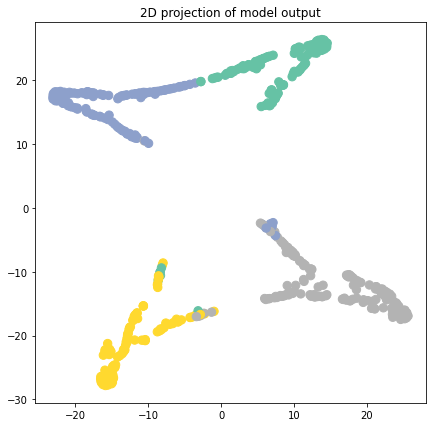

In [81]:
import torch.nn.functional as F

################# CONSTRUCTING MODEL AND LEARNING ##################

data = my_data
model = FFNN( layers = [t.nn.Linear, t.nn.Linear],
            activations = [ F.relu, F.softmax ],
            hidden_channels = [ 8 ],
            #dropouts = 0.5*t.ones(2),
            data = data); print(f"Current model: \n{model}")

result = learn( model = model, 
                optimizer = t.optim.Adam( model.parameters(), lr=0.01, weight_decay=5e-4 ), 
                criterion = t.nn.CrossEntropyLoss(), 
                epochs = 200,
                data = data)

visualize(result,TSNE_plot=True)

$\uparrow$ Accuracy가 0.2 언저리에서 시작해 꽤나 높게까지 훈련이 되긴 했고, TSNE 플롯도 꽤나 분류가 잘 되어 있는 모습을 볼 수 있지만 ......  

Current model: 
FFNN(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=4, bias=True)
  )
)

############################## LEARNING FINISHED! ##################################

Test Accuracy: 0.2611


C:\Users\echo_\AppData\Local\Temp\ipykernel_17272\4217564866.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activations[i]( self.layers[i]( *args ))
c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


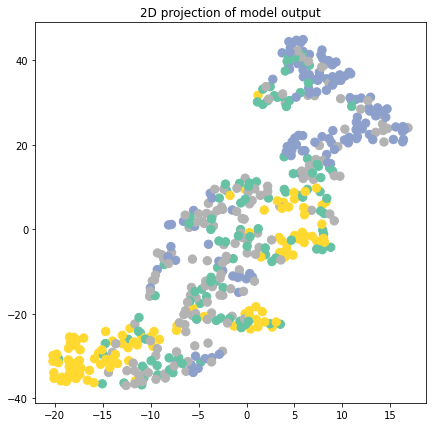

In [87]:
model = FFNN( layers = [t.nn.Linear, t.nn.Linear],
            activations = [ F.relu, F.softmax ],
            hidden_channels = [ 8 ],
            #dropouts = 0.5*t.ones(2),
            data = data); print(f"Current model: \n{model}")

result = learn( model = model, 
                optimizer = t.optim.Adam( model.parameters(), lr=0, weight_decay=0 ), 
                criterion = t.nn.CrossEntropyLoss(), 
                epochs = 1,
                data = data)

visualize(result, progress_plot=False, TSNE_plot=True)

$\uparrow$ 같은 형태의 모델로 훈련 없이 그대로 나온 output의 TSNE플롯도 어느 정도 클러스터링이 되어 있는 것을 볼 수 있습니다. 어느 정도 짐작은 했지만, 아무리 (비직관적인) 비선형 함수들을 통해 나온 함숫값들을 이용해 클래스를 나눴다고 해도, 그래도 어쨌든 연속함수들이다 보니 node-feature가 비슷하면 클래스도 비슷하게 분류되어서 발생하는 문제 같습니다.
$\downarrow$ 따라서 모듈러 함수를 이용해 기존의 node-feature들에 강한 irregularity를 부여해 봤습니다.

In [88]:
data_tensor_mod = t.remainder(data_tensor,0.5)

my_data_mod = dataframe( data_tensor_mod, data_class,train_mask,val_mask,test_mask)

$\downarrow$ 이제 다시 훈련 없이 output을 시각화 해 보면,

C:\Users\echo_\AppData\Local\Temp\ipykernel_17272\4217564866.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activations[i]( self.layers[i]( *args ))
c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(



############################## LEARNING FINISHED! ##################################

Test Accuracy: 0.2611


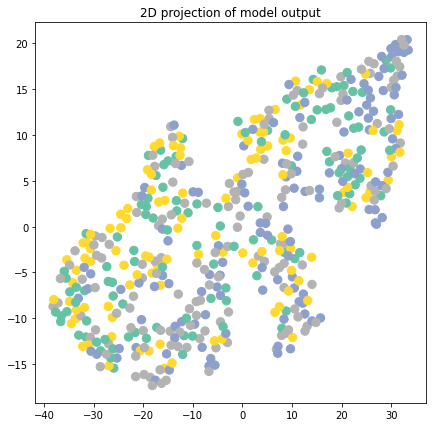

In [89]:
data = my_data_mod
result = learn( model = model, 
                optimizer = t.optim.Adam( model.parameters(), lr=0, weight_decay=0 ), 
                criterion = t.nn.CrossEntropyLoss(), 
                epochs = 1,
                data = data)

visualize(result, progress_plot=False, TSNE_plot=True)

$\uparrow$ 전보다는 더 흩뿌려진 것을 볼 수 있습니다. \
$\downarrow$ 이제 같은 모델로 다시 훈련을 해 보았습니다.

C:\Users\echo_\AppData\Local\Temp\ipykernel_17272\4217564866.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activations[i]( self.layers[i]( *args ))



############################## LEARNING FINISHED! ##################################

Test Accuracy: 0.4331


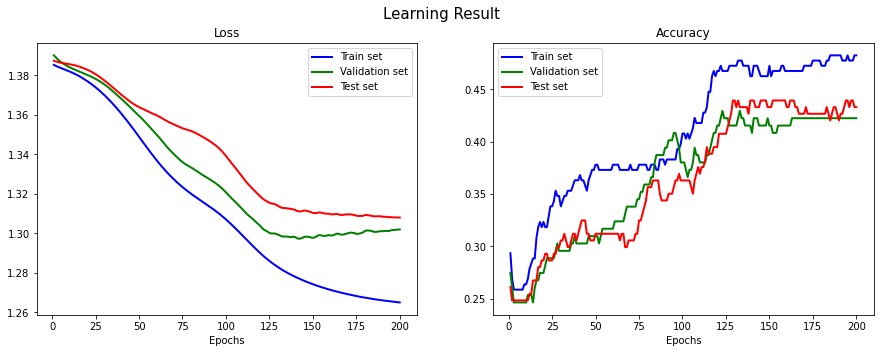

c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


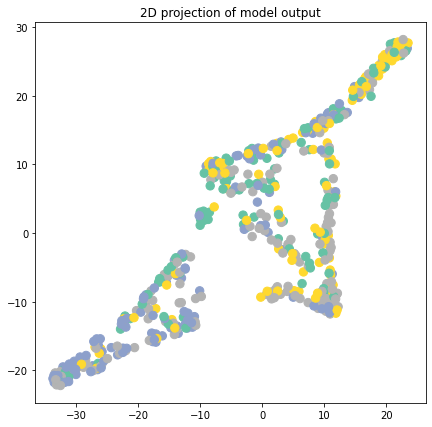

In [90]:
result = learn( model = model, 
                optimizer = t.optim.Adam( model.parameters(), lr=0.01, weight_decay=5e-4 ), 
                criterion = t.nn.CrossEntropyLoss(), 
                epochs = 200,
                data = data)

visualize(result, TSNE_plot=True)

$\uparrow$ feature에 모듈러 같은 discontinuity만 추가해도 잘 되던 MLP 모델이 갈피를 못 잡는 것을 확인할 수 있었습니다. 그래서 한층 더 깊고 큰 히든 레이어들을 사용해 봤습니다.

Current model: 
FFNN(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=4, bias=True)
  )
)


C:\Users\echo_\AppData\Local\Temp\ipykernel_17272\4217564866.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activations[i]( self.layers[i]( *args ))



############################## LEARNING FINISHED! ##################################

Test Accuracy: 0.4650


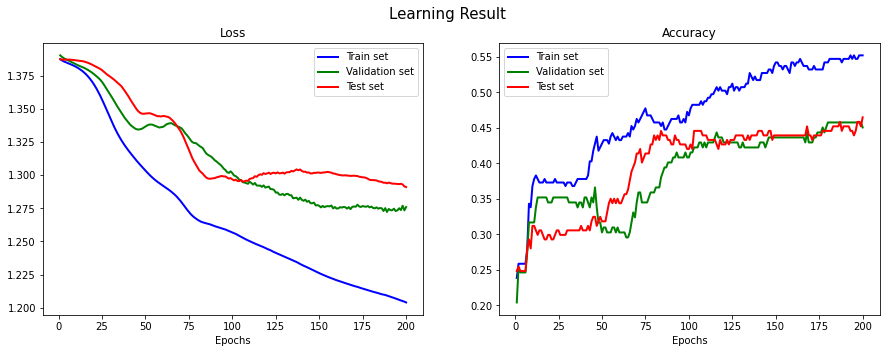

c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


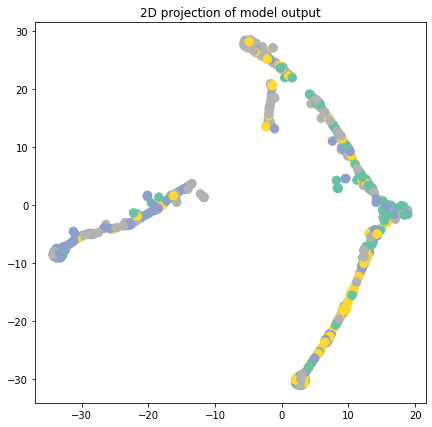

In [97]:
model = FFNN( layers = [t.nn.Linear, t.nn.Linear, t.nn.Linear],
            activations = [ F.relu, F.relu, F.softmax ],
            hidden_channels = [ 10, 20 ],
            #dropouts = 0.5*t.ones(2),
            data = data); print(f"Current model: \n{model}")

result = learn( model = model, 
                optimizer = t.optim.Adam( model.parameters(), lr=0.01, weight_decay=5e-4 ), 
                criterion = t.nn.CrossEntropyLoss(), 
                epochs = 200,
                data = data)

visualize(result, TSNE_plot=True)

$\uparrow$ 그래도 결과는 여전히 비슷함을 확인할 수 있었습니다.

## 결론

* 이미 어느 정도 직관적으로 잘 만들어진 node feature들에 대해선 간단한 MLP 모델도 잘 작동하지만, 조금만 discotinuity나 irregularity를 추가해도 갈피를 못 잡는 것을 확인할 수 있었습니다. 
* 하지만 이 노트를 짜게 된 제 주된 관심은, 여기서 더 나아가 비 직관적인 node feature들끼리의 ground truth(class) 정보를 활용하여, *같은 클래스끼리 촘촘히 연결된 그래프 구조를 부여하여 GNN 학습을 활용하면 MLP보다 나은 해결력을 보일까?* 였지만, 아직 제 부족한 코딩 실력 때문인지(...) torch에 커스텀 그래프 구조를 부여한 데이터프레임을 아직 제대로 적용해보지 못했습니다. 이는 빠르게 다음 주제로 다뤄보겠습니다.

**다음 주제**
* Dropout이 추가되어 loss값이 흔들릴 때도 잘 적용할 수 있도록 다양한 stopping criterion들을 시도해보기
* (위에 언급한 대로) Raw data에 학습에 도움이 될 만한 커스텀 그래프 구조를 부여하여 MLP 같은 비-그래프 학습과 그래프 학습을 비교해보기
* 벡터 임베딩 조차 되지 않은 추상적 데이터들을 서로 다른 방법으로 임베딩하여 성능 비교해 보기
* (기회가 된다면) torch의 torch.tensordot을 이용하여, 도함수 텐서들의 contraction을 직접 계산해 가며 back-propagation 알고리즘을 짜 보고 [(참고자료 링크)](https://github.com/hkyoon94/ML/blob/main/Notes%20on%20ML.pdf), torch의 내장 optimizer와 속도 및 성능 비교해보기